# Flatiron School Mod_7 project - Modelling Notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from glob import glob
# from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import notebook_toolkit as nt #external scripts for processing data


##initialise random state for reproducibility
random_state = np.random.seed (42)

#suppress inline warnings
warnings.filterwarnings('ignore')



In [4]:
#steps here don't work for a scikit learn pipeline as the steps are too simple - it would be an overkill

filenames = glob('pagespeed_csvs/pagespeed_results_*.csv')
dataframes = [pd.read_csv(f) for f in filenames]
pagespeed_df = pd.concat(dataframes)
pagespeed_df.columns = (['address',
                         'first_contentful_paint',
                         'time_to_interactive',
                         'time_to_first_byte',
                         'dom_size',
                         'boot_up_time',
                         'first_meaningful_paint',
                         'speed_index',
                         'total_blocking_time',
                         'network_requests',
                         'total_byte_weight'])
pagespeed_df.drop_duplicates(subset = 'address',keep='first', inplace = True)
pagespeed_df.dropna(inplace = True)
for index in range(1,10):
    pagespeed_df.iloc[:,index] = pagespeed_df.iloc[:,index].astype(np.float64)
pagespeed_df.drop(labels = ['address'], axis = 1, inplace = True)
pagespeed_df.reset_index(inplace=True)
pagespeed_df.drop(labels = ['index'], axis = 1, inplace = True)

take a sqrt
sub lowest value for feature

clustering - 

In [5]:
pagespeed_df

,first_contentful_paint,time_to_interactive,time_to_first_byte,dom_size,boot_up_time,first_meaningful_paint,speed_index,total_blocking_time,network_requests,total_byte_weight
0,1275.0,1410.0,609.853,137.0,8.471,1410.0,2129.675696,0.0,43.0,309579.0
1,908.0,908.0,883.182,676.0,36.641,908.0,1870.638039,0.0,29.0,608118.0
2,1035.0,1193.5,768.089,1339.0,436.294,1165.0,2184.859293,18.5,54.0,1248103.0
3,590.0,2785.0,358.059,326.0,282.680,656.0,1180.783589,25.5,45.0,5422097.0
4,708.0,4630.0,385.969,2195.0,1796.401,748.0,1771.028798,60.0,326.0,2833017.0
...,...,...,...,...,...,...,...,...,...,...
70130,580.0,3963.5,590.610,1921.0,2567.223,1612.0,1637.243066,973.5,85.0,1832888.0
70131,1219.0,10640.0,238.884,1184.0,3168.110,1219.0,4341.616309,208.0,575.0,5890014.0
70132,953.0,9365.5,1590.511,2298.0,4762.252,953.0,4540.687065,625.5,457.0,6759435.0
70133,712.0,15833.5,402.752,1077.0,9590.345,1077.0,6676.864039,667.5,1093.0,7843296.0


In [6]:
#create a pure dataset to test the model at the end of training

final_validation_dataset = pagespeed_df.iloc[50001:,:]
final_validation_dataset.reset_index(inplace=True)

In [7]:
#create a dataset to use for modelling

training_dataset = pagespeed_df.iloc[:50000,:]
training_dataset.reset_index(inplace=True)
training_dataset.drop(columns = "index", inplace=True)

In [8]:
#create X and y for training

X = training_dataset.drop(columns = "speed_index")
y = training_dataset.speed_index

In [9]:
#train, test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = random_state)

In [10]:
#scale data

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# Linear Regression - Baseline Model

In [2]:
crossvalidation = KFold(n_splits=3, shuffle=True, random_state = random_state)

In [9]:
lin_reg_obj  = LinearRegression()

In [10]:
lin_reg_kfold = cross_validate(lin_reg_obj, 
                               X_train_scaled, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [11]:
print(f'K-fold test score mean r^2 = {round(np.mean(lin_reg_kfold["test_score"]), 2)}')
print(f'K-fold train score mean r^2 = {round(np.mean(lin_reg_kfold["train_score"]), 2)}')

K-fold test score mean r^2 = 0.76
K-fold train score mean r^2 = 0.76


In [12]:
lin_reg_model = lin_reg_obj.fit(X_train_scaled, y_train)

In [13]:
print(f'R^2 error from fitting a simple linear regression to this data is {round(r2_score(y_test,lin_reg_obj.predict(X_test_scaled)),2)} test data set')


R^2 error from fitting a simple linear regression to this data is 0.77 test data set


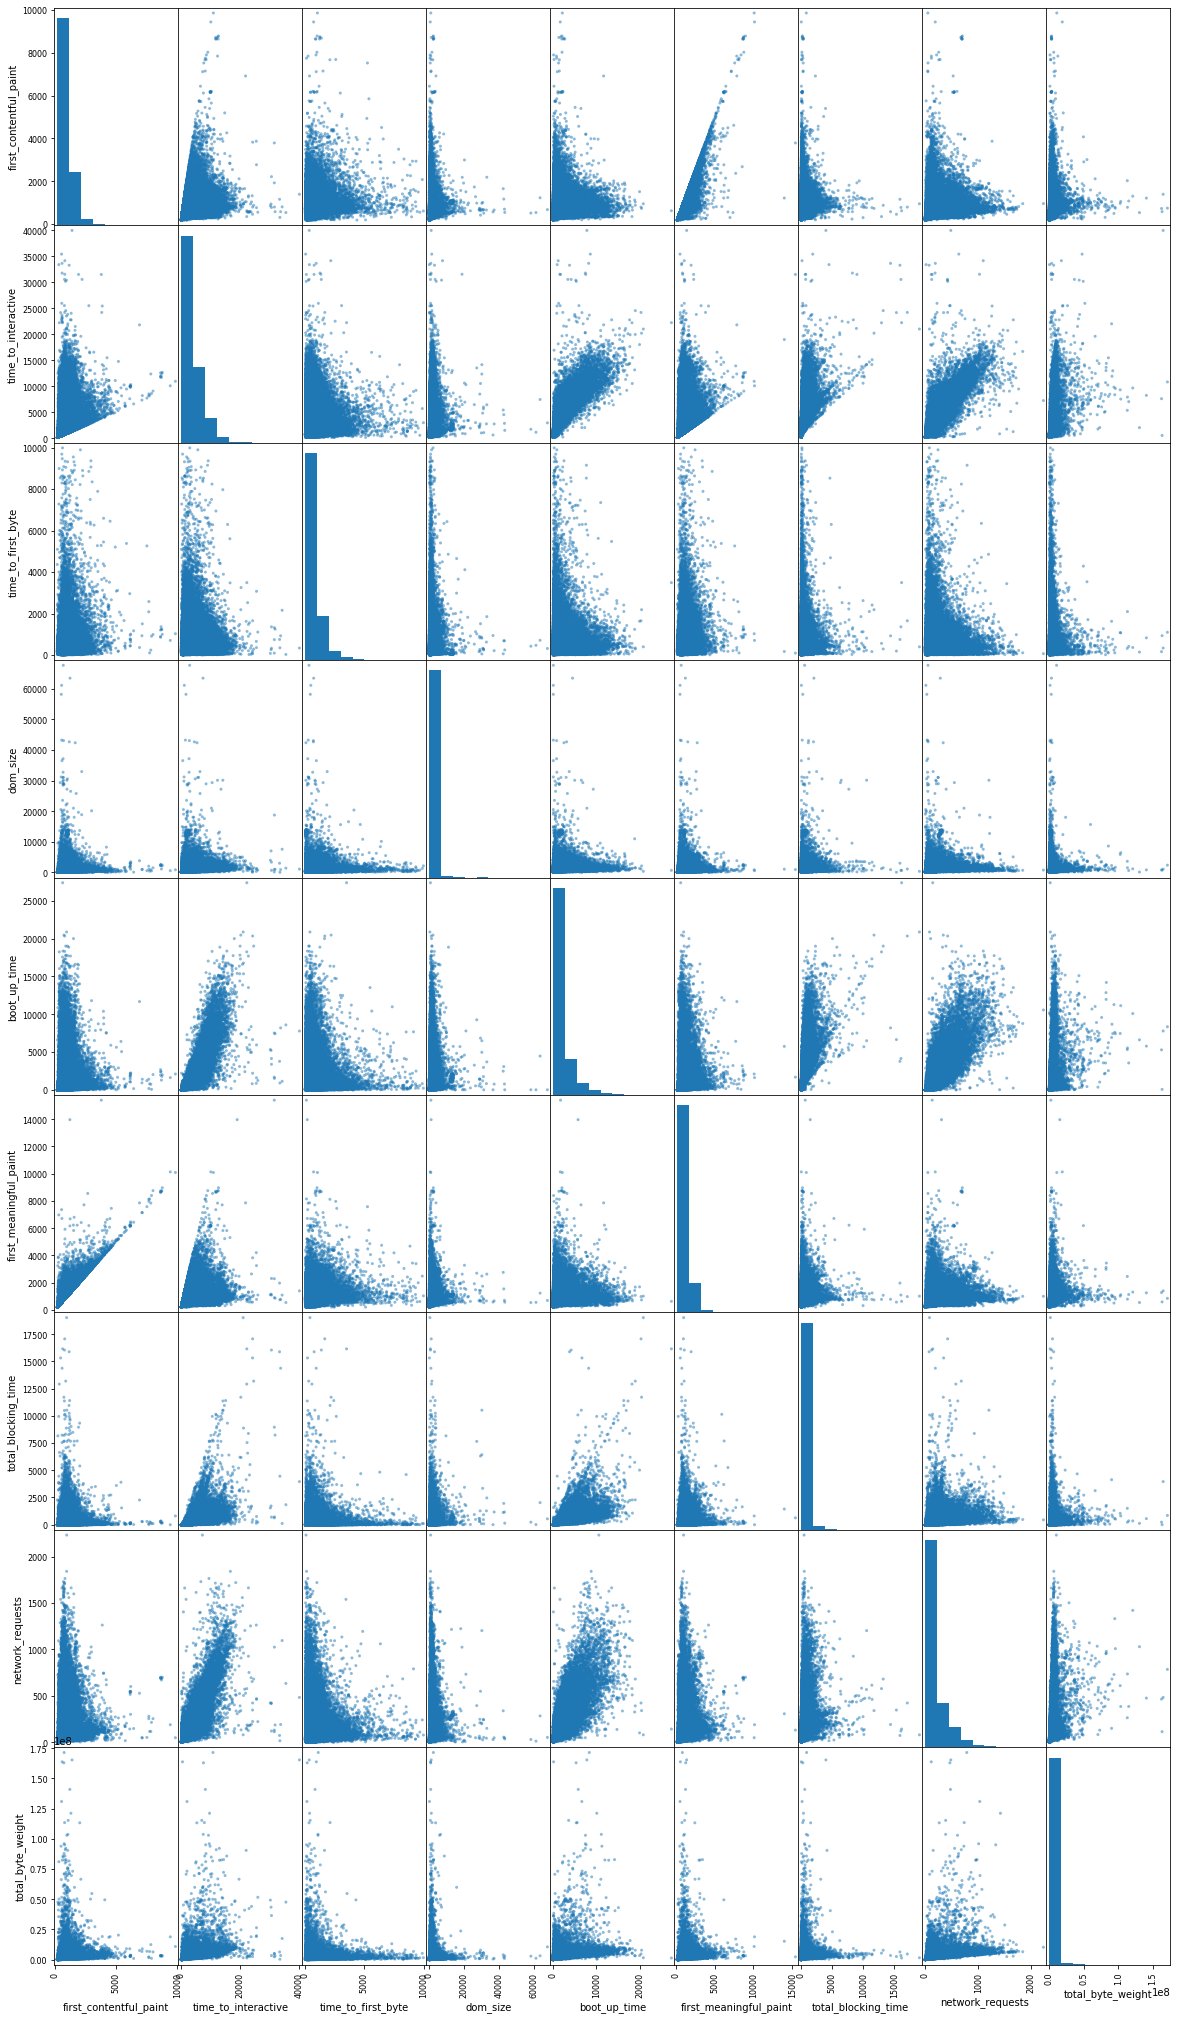

In [93]:
pd.plotting.scatter_matrix(X_train, figsize=(20,36));

In [96]:
X_train_log = pd.DataFrame(columns = ['first_contentful_paint', 
                                      'time_to_interactive', 
                                      'time_to_first_byte',
                                      'dom_size',
                                      'boot_up_time',
                                      'first_meaningful_paint',
                                      'total_blocking_time',
                                      'network_requests',
                                      'total_byte_weight'])
non_normal = ['first_contentful_paint', 
              'time_to_interactive', 
              'time_to_first_byte',
              'dom_size',
              'boot_up_time',
              'first_meaningful_paint',
              'total_blocking_time',
              'network_requests',
              'total_byte_weight']
for feat in non_normal:
    X_train_log[feat] = X_train[feat].map(lambda x: np.log(x))

ValueError: Axis limits cannot be NaN or Inf

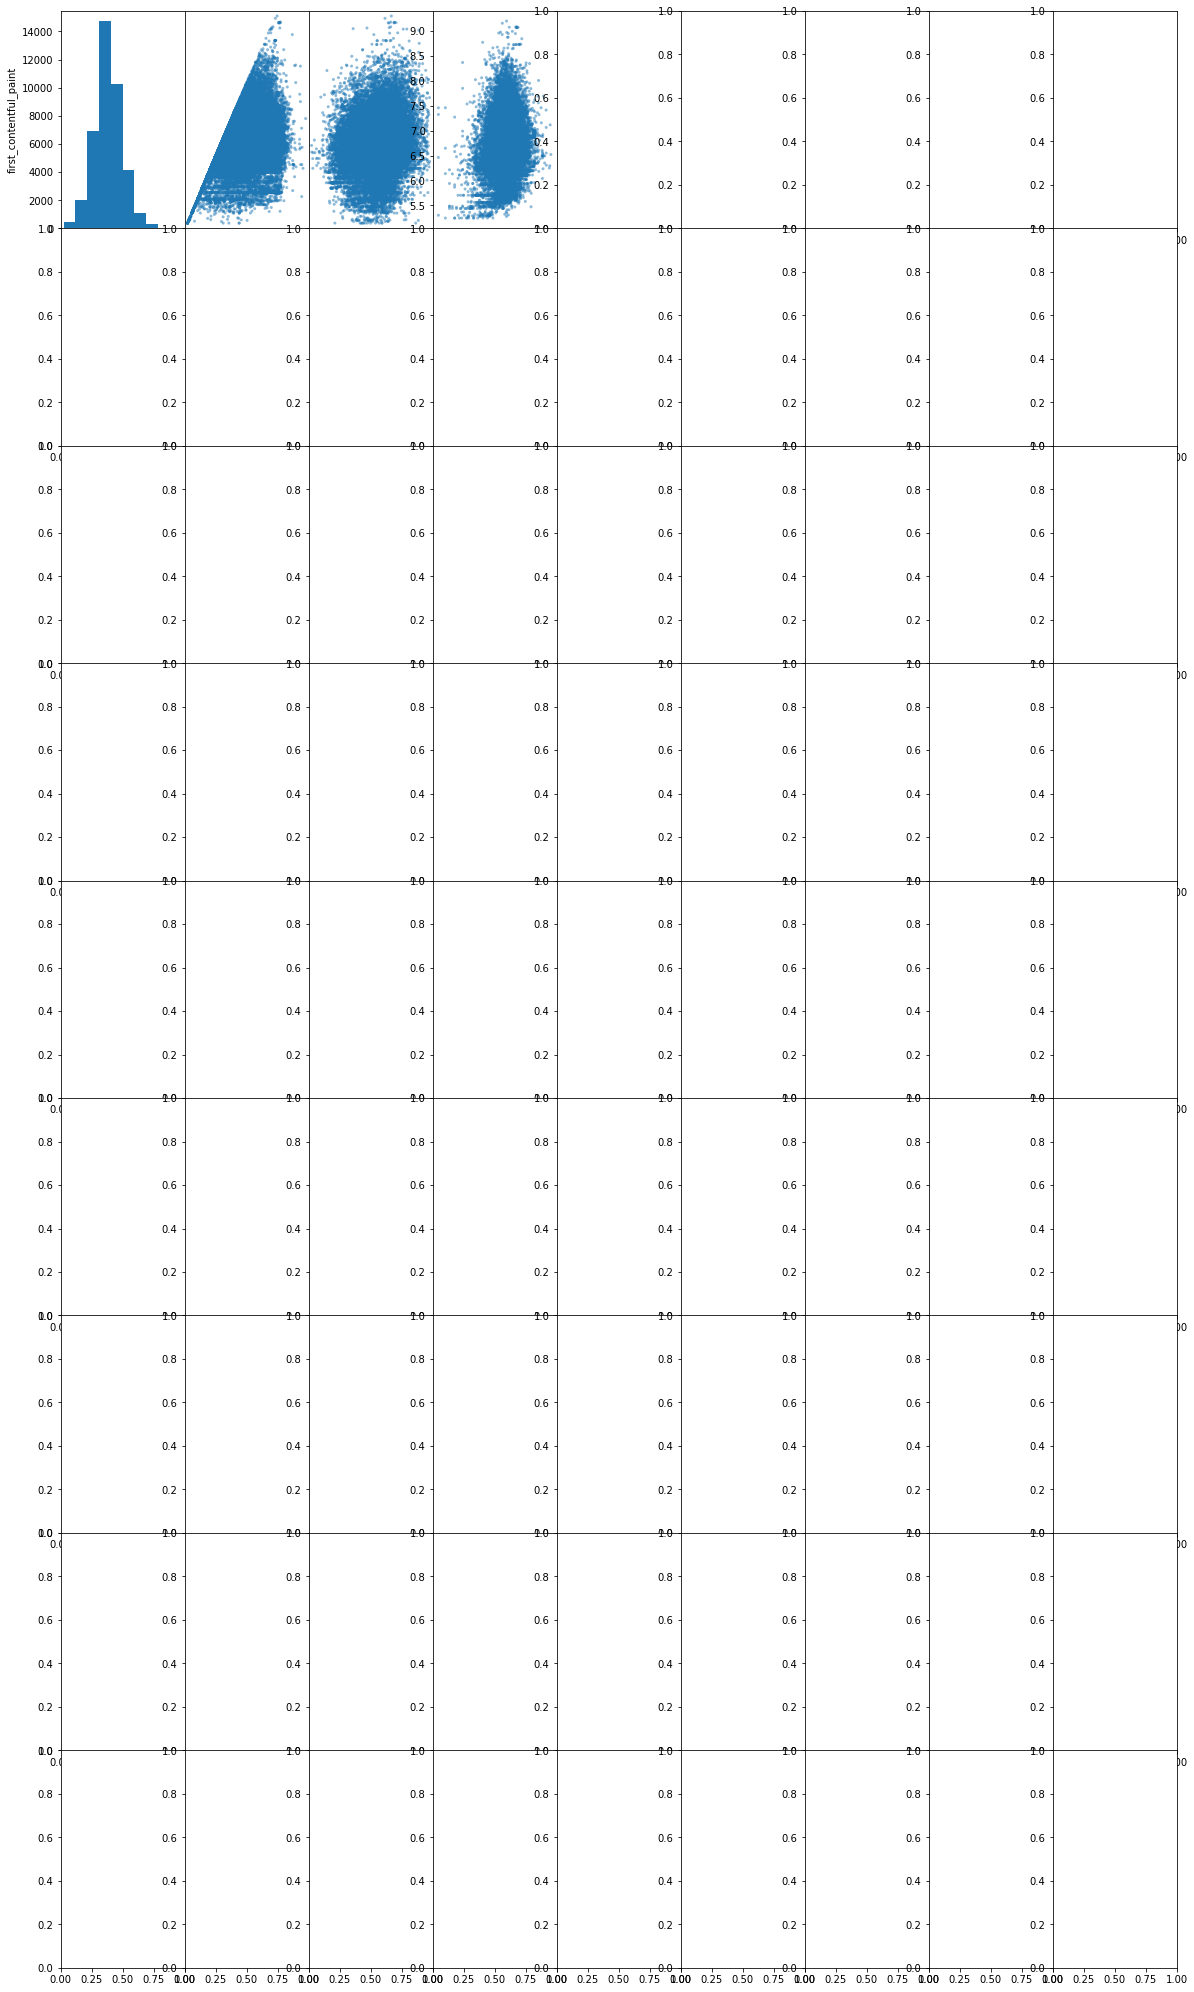

In [98]:
pd.plotting.scatter_matrix(X_train_log, figsize=(20,36));

In [99]:
X_train

,first_contentful_paint,time_to_interactive,time_to_first_byte,dom_size,boot_up_time,first_meaningful_paint,total_blocking_time,network_requests,total_byte_weight
39087,710.0,7415.5,5325.725,1357.0,4411.349,710.0,1155.0,322.0,4496031.0
30893,410.0,1013.0,32.532,1284.0,237.132,410.0,7.0,22.0,310849.0
45278,451.0,1689.0,372.077,208.0,859.624,451.0,37.0,52.0,646336.0
16398,676.0,676.0,643.446,2786.0,5.756,676.0,0.0,12.0,145880.0
13653,527.0,527.0,434.179,44.0,4.499,527.0,0.0,15.0,1165175.0
...,...,...,...,...,...,...,...,...,...
11284,540.0,4720.0,415.516,3088.0,1007.423,665.0,61.5,331.0,2341691.0
44732,686.0,3117.0,1456.856,1068.0,1291.731,706.0,35.5,152.0,1289481.0
38158,580.0,6611.5,370.985,1354.0,2728.637,580.0,334.0,399.0,2526449.0
860,685.0,746.0,306.076,44.0,61.513,746.0,0.0,14.0,346228.0


In [ ]:
#get guidance on doing log transforms:

i) Is it s a viable strategy to impute zero values column median?
ii) Do we need to scale log data? I guess not...

# Decision Tree Regressor

In [101]:
dec_tree_obj  = DecisionTreeRegressor()

In [105]:
dec_tree_kfold = cross_validate(dec_tree_obj, 
                               X_train, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [106]:
dec_tree_kfold

{'fit_time': array([1.35188198, 1.30553699, 1.32193589, 1.28630829, 1.19623613,
        1.21320176, 1.19324994, 1.18138909, 0.76027608, 0.82431078]),
 'score_time': array([0.00837183, 0.00532317, 0.00939631, 0.00967503, 0.0179069 ,
        0.00525212, 0.00533795, 0.00813079, 0.00365305, 0.00368619]),
 'test_score': array([0.5793715 , 0.58078923, 0.56964407, 0.53427206, 0.56508903,
        0.60321148, 0.54479158, 0.59471616, 0.5647435 , 0.58232594]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

This is model is really badly overfitting on the training data

Do we need to use scaled data here? I don't think so...

# Decision Tree Regressor Regularised

In [90]:
dec_tree_obj_reg  = DecisionTreeRegressor(min_samples_leaf=10)

In [91]:
dec_tree_reg_kfold = cross_validate(dec_tree_obj_reg, 
                               X_train, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [92]:
dec_tree_reg_kfold

{'fit_time': array([0.62637115, 0.64698982, 0.62787294, 0.63129497, 0.63250613,
        0.62551594, 0.62980294, 0.60125089, 0.42277312, 0.41977692]),
 'score_time': array([0.00326467, 0.00721812, 0.00353909, 0.00440621, 0.00336385,
        0.00375104, 0.00369716, 0.00441003, 0.00233698, 0.00395799]),
 'test_score': array([0.70840992, 0.72062986, 0.71909391, 0.74793525, 0.70336935,
        0.71481289, 0.7158099 , 0.73908255, 0.72547688, 0.72748958]),
 'train_score': array([0.85953352, 0.8561403 , 0.85811034, 0.85436623, 0.85910552,
        0.85915717, 0.85619071, 0.85316943, 0.85605757, 0.85571813])}

# Random Forest Regressor

In [3]:
rand_forest_obj  = RandomForestRegressor()

In [109]:
rand_forest_kfold = cross_validate(rand_forest_obj, 
                               X_train, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [110]:
rand_forest_kfold

{'fit_time': array([79.99479294, 79.76776814, 79.45951796, 79.57554507, 74.50635791,
        74.60597897, 74.730757  , 74.70257092, 51.01027393, 51.02853012]),
 'score_time': array([1.99373507, 2.01834297, 1.93409324, 2.08645511, 0.3737061 ,
        0.40085196, 0.40327883, 0.3944602 , 0.21986794, 0.23955178]),
 'test_score': array([0.78924023, 0.79685966, 0.79219834, 0.76422986, 0.7887524 ,
        0.79706424, 0.78400678, 0.81045417, 0.80217278, 0.78176446]),
 'train_score': array([0.9706269 , 0.97040972, 0.97002489, 0.97087586, 0.97034983,
        0.97023976, 0.97065244, 0.97009259, 0.97032145, 0.97054049])}

This model is awesome

To so:

* SVM regressor - linear and non-linear
* Decision Trees Cart Algorithm
* Interactions
* Clustering?
* Ridge, Lasso, Elasinet
* Gridsearch CV optimisation of candidate models


# SVM Linear Regressor

In [76]:
svm_reg_lin_obj = LinearSVR(epsilon = 1.5)

In [77]:
svm_reg_lin_kfold = cross_validate(svm_reg_obj, 
                               X_train_scaled, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [78]:
svm_reg_lin_kfold

{'fit_time': array([0.10670066, 0.12488604, 0.15097427, 0.12762809, 0.14071488,
        0.13309598, 0.11013031, 0.10617232, 0.08828712, 0.07710195]),
 'score_time': array([0.00205612, 0.00170994, 0.00173187, 0.00135088, 0.00153923,
        0.00152898, 0.00127983, 0.00170994, 0.00125694, 0.00119019]),
 'test_score': array([0.75036835, 0.75410743, 0.74720392, 0.70443898, 0.75411276,
        0.75775789, 0.75489517, 0.76417607, 0.76058463, 0.74661129]),
 'train_score': array([0.74987204, 0.74910652, 0.75014454, 0.75424999, 0.74949338,
        0.74840074, 0.74923422, 0.74839429, 0.74875119, 0.7500637 ])}

# SVM Poly Regressor

In [84]:
svm_reg_poly_obj = SVR(kernel='poly', degree = 2, C = 100, epsilon = 0.1)

In [85]:
svm_reg_poly_kfold = cross_validate(svm_reg_poly_obj, 
                               X_train_scaled, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [86]:
svm_reg_poly_kfold


{'fit_time': array([110.64160895, 110.22855186, 110.17512083, 107.01757908,
        128.27990675, 131.09846282, 131.62319374, 128.9664619 ,
         69.16127062,  63.03120804]),
 'score_time': array([5.00791407, 4.92623591, 4.93848896, 4.46259284, 5.51044106,
        6.40363407, 6.18417788, 6.472821  , 2.42267013, 2.39921689]),
 'test_score': array([ 0.0853552 ,  0.01981855, -0.00051021,  0.13588822,  0.2782891 ,
         0.13070214,  0.25124755,  0.2408972 ,  0.08673406,  0.18521362]),
 'train_score': array([0.18048918, 0.18216414, 0.18228855, 0.17836761, 0.16623988,
        0.17175629, 0.17769117, 0.17602947, 0.17714674, 0.17687959])}

In [87]:
svm_reg_poly_obj = SVR(kernel='poly', degree = 2, C = 0.1, epsilon = 0.1)

In [88]:
svm_reg_poly_kfold = cross_validate(svm_reg_poly_obj, 
                               X_train_scaled, 
                               y_train, scoring='r2', 
                               cv=crossvalidation, 
                               return_train_score = True, 
                               n_jobs=-1)

In [89]:
svm_reg_poly_kfold

{'fit_time': array([149.28588104, 199.33494401, 203.95414019, 148.03211427,
        188.75253701, 177.8305788 , 171.58037305, 134.17970777,
         92.05614281, 114.12295508]),
 'score_time': array([6.17438817, 6.05337024, 5.38090277, 5.56100893, 5.503196  ,
        5.21876931, 5.16623902, 5.45430827, 3.02413893, 2.28764725]),
 'test_score': array([0.22678448, 0.24981503, 0.22308668, 0.24756743, 0.23564214,
        0.23297111, 0.23926996, 0.21411701, 0.21583266, 0.24900738]),
 'train_score': array([0.23382904, 0.23186442, 0.23637453, 0.23366469, 0.23518895,
        0.23221544, 0.23447401, 0.23846898, 0.23742822, 0.23460491])}

# Clustering

In [40]:
cluster_df = pagespeed_df

In [260]:
k_means_obj = KMeans(n_clusters = 1000, n_jobs = -1)

In [261]:
k_means_obj.fit(cluster_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1000, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [262]:
cluster_assignments = k_means_obj.predict(cluster_df)

In [263]:
cluster_assignments_df = pd.DataFrame(cluster_assignments)

In [264]:
clustergroup_df = pd.DataFrame(data = cluster_assignments_df.groupby(0)[0].count())
clustergroup_df.columns = ['member_count']
clustergroup_df.reset_index(inplace = True)
clustergroup_df.columns = ['cluster_number', 'member_count']
clustergroup_df.sort_values(by = ['member_count'], axis = 0, inplace = True, ascending = False)

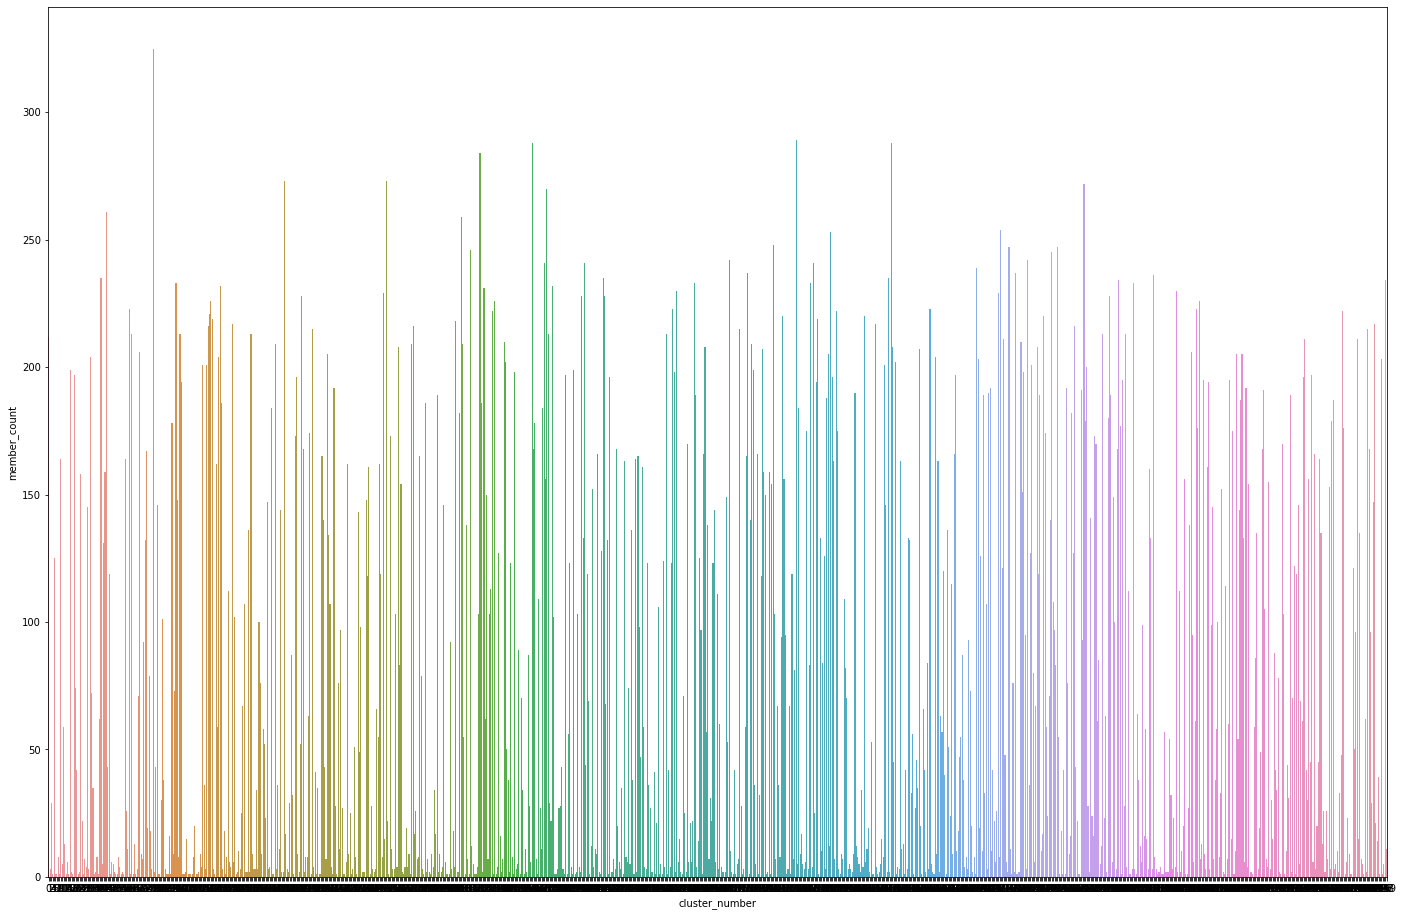

In [272]:
fig_dims = (24, 16)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="cluster_number", y="member_count", data=clustergroup_df.head(1000));

In [271]:
clustergroup_df.head(80).sum()

cluster_number    38904
member_count      18816
dtype: int64

To do:

1) Use PCA to reduce components down and train the model on that

2) Use clustering to identify new features and onehot encode them

3) Don't use outlier detection on clustering as we don't want to lose data

4) Use agglomerative hierarchical clustering and visualise data to make decisions around where to make new features

5) Experiment with Gradient Boosting Regressor to see if performance improves

# Model Optimisation

The best candidate model is the RandomForestRegressor. We need to optimise this further to get the best results using GridSearchCV

In [281]:
param_grid = {'max_depth':range(10,50,10),
              'min_samples_leaf':[5,50,500]}
opt_model_1 = GridSearchCV(rand_forest_obj,
                           param_grid,
                           cv=crossvalidation,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1,
                           verbose=2)
opt_model_1.fit(X_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 23.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ve

In [288]:
print(f'Best parameters for this optimisation: {opt_model_1.best_params_}')
print(f'Best r^2 for this optimisation: {round(opt_model_1.best_score_,2)}')

Best parameters for this optimisation: {'max_depth': 20, 'min_samples_leaf': 5}
Best r^2 for this optimisation: 0.79


In [11]:
param_grid = {'max_depth':range(15,25,1),
              'min_samples_leaf':range(1,10,1)}
opt_model_1 = GridSearchCV(rand_forest_obj,
                           param_grid,
                           cv=crossvalidation,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1,
                           verbose=2)
opt_model_1.fit(X_train,y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 57.4min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             ver

In [12]:
print(f'Best parameters for this optimisation: {opt_model_1.best_params_}')
print(f'Best r^2 for this optimisation: {round(opt_model_1.best_score_,2)}')

Best parameters for this optimisation: {'max_depth': 23, 'min_samples_leaf': 3}
Best r^2 for this optimisation: 0.79


# Fitting Optimisal Model

In [13]:
rand_forest_opt  = RandomForestRegressor(max_depth = 23,
                                         min_samples_leaf =3)

In [14]:
rand_forest_opt.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=23, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [18]:
print(f'R^2 error from fitting a random forest regressor to this data is {round(r2_score(y_test,rand_forest_opt.predict(X_test)),2)}')

R^2 error from fitting a random forest regressor to this data is 0.8


In [19]:
rand_forest_opt.feature_importances_

array([0.03937045, 0.56629032, 0.20307186, 0.01986105, 0.02776161,
       0.0697025 , 0.01935793, 0.02067694, 0.03390735])

In [73]:
importances = pd.DataFrame(list(zip(rand_forest_opt.feature_importances_, X_train.columns)))
importances.columns = ['feature_importance', 'feature']
importances = importances[['feature','feature_importance']]
importances.feature_importance = round(importances.feature_importance * 100,2)

importances.sort_values(by = 'feature_importance', ascending = False, inplace = True)

In [74]:
importances

,feature,feature_importance
1,time_to_interactive,56.63
2,time_to_first_byte,20.31
5,first_meaningful_paint,6.97
0,first_contentful_paint,3.94
8,total_byte_weight,3.39
4,boot_up_time,2.78
7,network_requests,2.07
3,dom_size,1.99
6,total_blocking_time,1.94


Text(0.5, 0, 'Feature Importance')

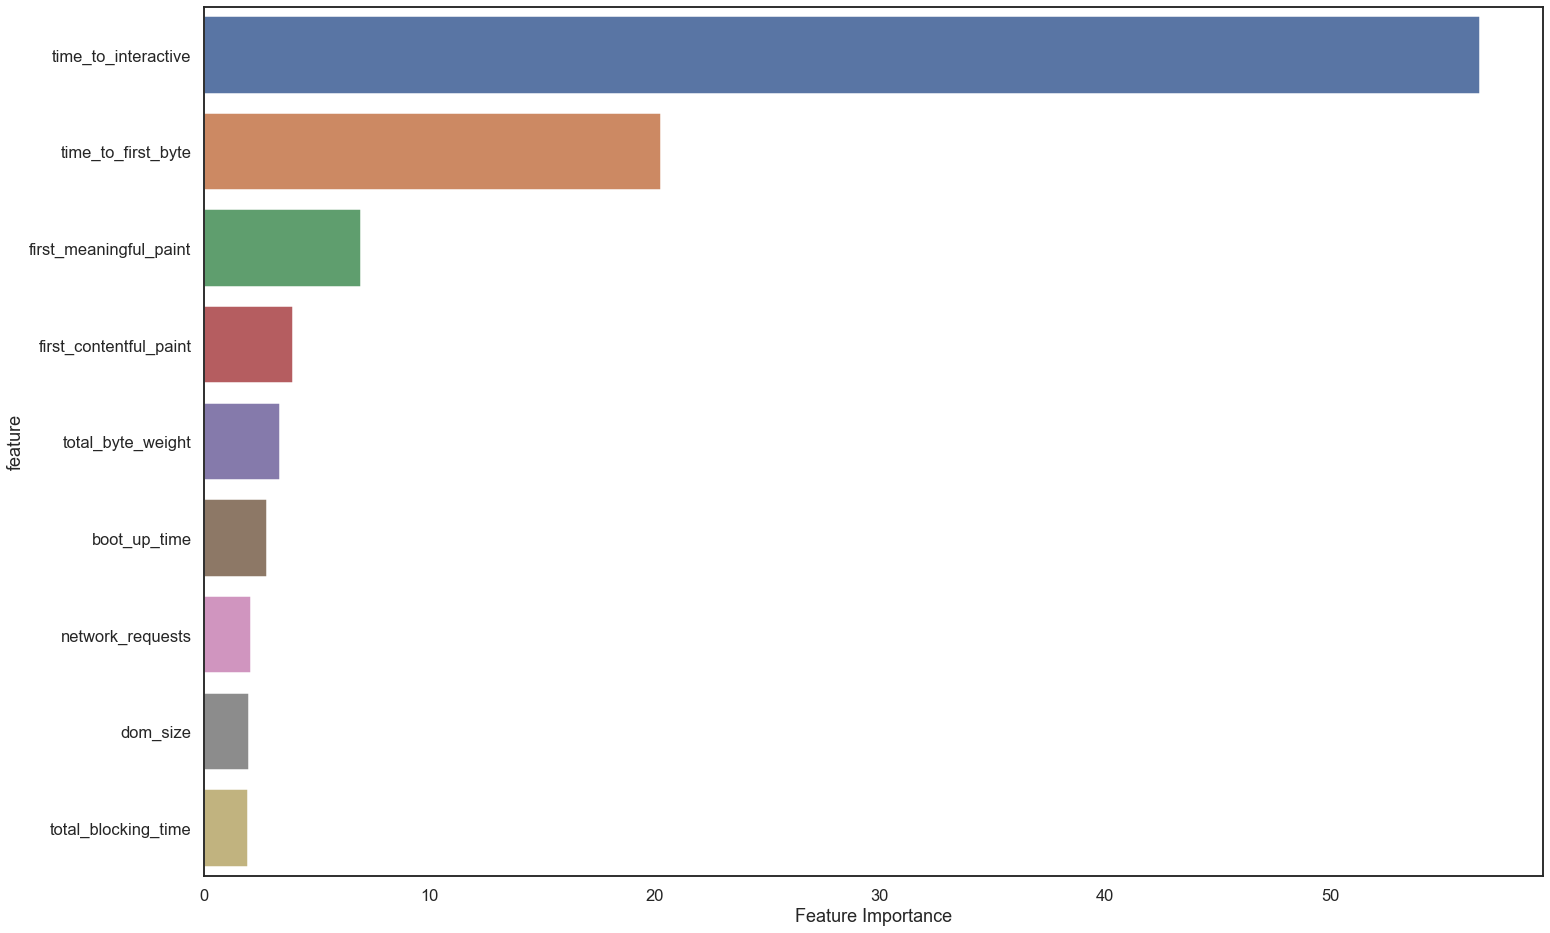

In [75]:
fig_dims = (24, 16)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x='feature_importance', y='feature', data=importances)
ax.set_xlabel('Feature Importance')